# Modeling spike data with `multidms.jaxmodels`

In [1]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
df = pd.read_csv("training_functional_scores_no_agg.csv", keep_default_na=False)

df.query("replicate == 1", inplace=True)

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

df.query("(pre_count >= 100) & (post_count >= 10)", inplace=True)

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,Delta,1,,0,5027212,4967837
1,Delta,1,A1015D,1,978,291
2,Delta,1,A1015D E1188Q,2,796,268
3,Delta,1,A1015D T1027S,2,841,63
5,Delta,1,A1015T,1,1051,441
...,...,...,...,...,...,...
174467,Omicron_BA2,1,Y91H N710T A1070G V1129L,4,550,88
174469,Omicron_BA2,1,Y91N D138N Q474E,3,217,26
174470,Omicron_BA2,1,Y91N N603I S1252Y,3,792,160
174471,Omicron_BA2,1,Y91T N137T F375T F562L Q804H,5,627,13


Our model doesn't make sense for nonsense variants. We truncate, and then filter no missense before first nonsense.

In [3]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

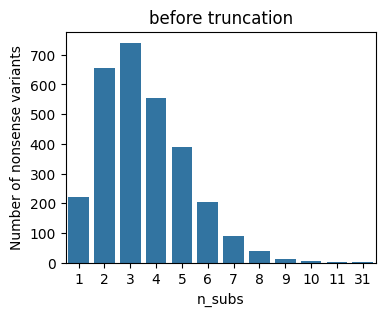

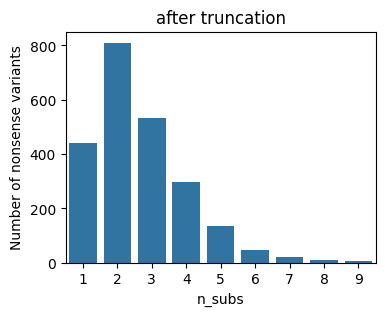

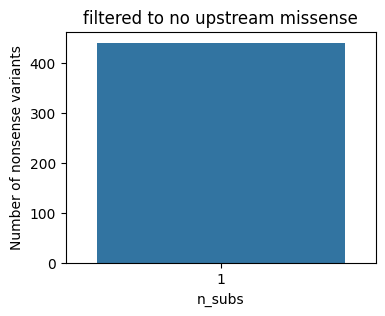

In [4]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

df = df.apply(truncate_nonsense, axis=1)
# re-aggregate identical variants
df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("after truncation")
plt.show()

df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("filtered to no upstream missense")
plt.show()

Functional scores

In [5]:
pseudocount = 0.5
df["func_score"] = np.log2(df["post_count"] + pseudocount) - np.log2(df["pre_count"] + pseudocount)

def group_wt_ref(df_group):
    wts = df_group.query("aa_substitutions == ''")
    assert wts.shape[0] == 1, wts
    df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
    return df_group

df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

In [6]:
df.shape

(143571, 7)

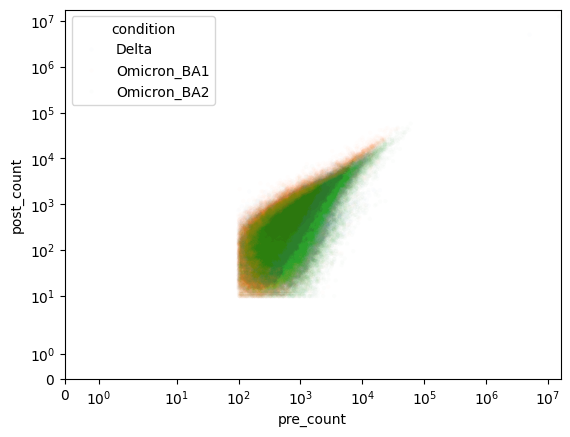

In [7]:
sns.scatterplot(x=df.pre_count.astype(float), y=df.post_count.astype(float), hue=df.condition, s=10, alpha=0.01)
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlim(0, None) 
plt.ylim(0, None)
plt.show()

In [8]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference="Omicron_BA1",
)

In [9]:
data_sets = {d: multidms.jaxmodels.Data(multidms_data, d) for d in multidms_data.conditions}

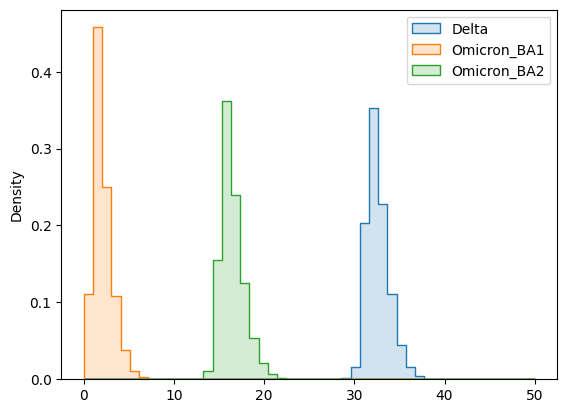

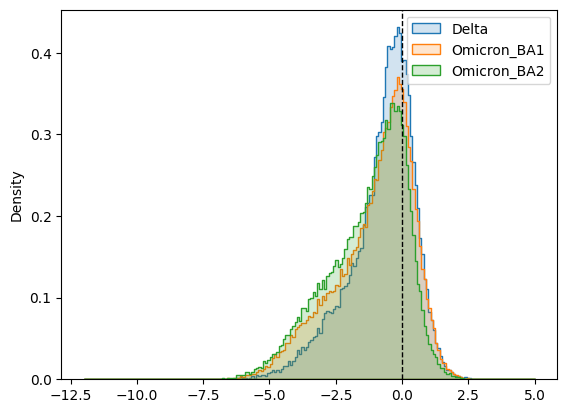

In [10]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

In [29]:
model, obj_traj = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg_α=0.0,
    l2reg_β=0.0,
    fusionreg=2e-3,
    maxiter=100,
    obj_tol=1e-4,
    block_kwargs=dict(tol=1e-10, maxiter=100),
)

iteration 1
  α block:
    iterations=100
    error=2.87e-09
    α={'Delta': 4.61, 'Omicron_BA1': 4.77, 'Omicron_BA2': 5.5}
  φ block:
    iterations=100
    error=1.62e+00
    Delta shift sparsity=10.43%
    Omicron_BA2 shift sparsity=11.76%
  Δobj=7.15e-01
iteration 2
  α block:
    iterations=79
    error=3.07e-11
    α={'Delta': 4.67, 'Omicron_BA1': 4.91, 'Omicron_BA2': 5.33}
  φ block:
    iterations=100
    error=1.16e+00
    Delta shift sparsity=22.58%
    Omicron_BA2 shift sparsity=19.17%
  Δobj=7.31e-02
iteration 3
  α block:
    iterations=63
    error=4.01e-11
    α={'Delta': 4.72, 'Omicron_BA1': 4.99, 'Omicron_BA2': 5.3}
  φ block:
    iterations=100
    error=1.83e+00
    Delta shift sparsity=30.34%
    Omicron_BA2 shift sparsity=24.72%
  Δobj=4.42e-02
iteration 4
  α block:
    iterations=100
    error=1.08e-08
    α={'Delta': 4.76, 'Omicron_BA1': 5.04, 'Omicron_BA2': 5.32}
  φ block:
    iterations=100
    error=4.01e-01
    Delta shift sparsity=36.02%
    Omicron_BA2 sh

In [30]:
model.α

{'Delta': Array(6.19652233, dtype=float64),
 'Omicron_BA1': Array(5.44198043, dtype=float64),
 'Omicron_BA2': Array(6.12988406, dtype=float64)}

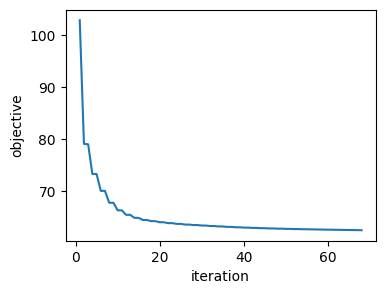

In [31]:
plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, len(obj_traj)), obj_traj[1:])
plt.xlabel("iteration")
plt.ylabel("objective")
plt.show()

In [32]:
for d in model.φ:
    print(d, model.φ[d].β0, model.α[d])

Delta 0.28004049519752433 6.196522327843844
Omicron_BA1 0.7469998240804627 5.441980432314026
Omicron_BA2 -0.812288796405747 6.129884058868317


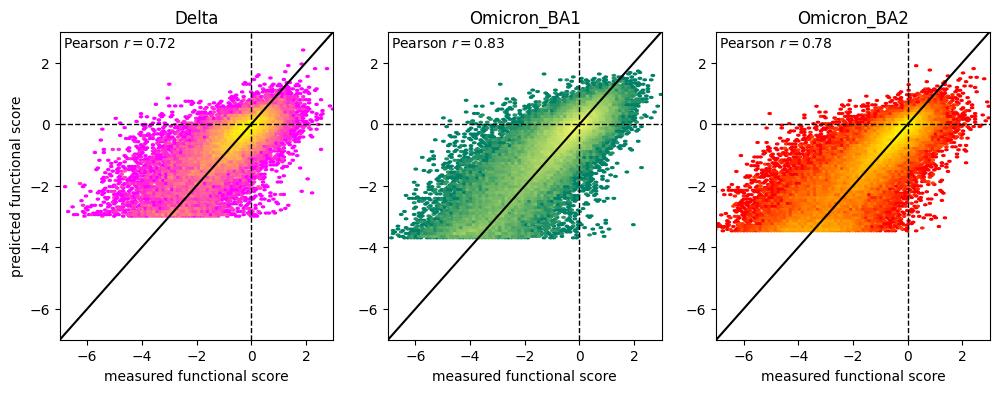

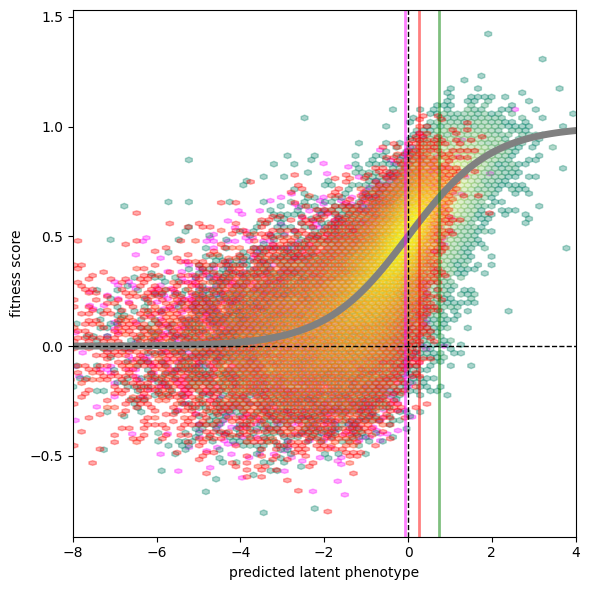

In [33]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $r={scipy.stats.pearsonr(y, y_pred).statistic:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-7, 3)
    plt.ylim(-7, 3)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()


plt.figure(figsize=(6, 6))
φ_grid = np.linspace(-8, 4, 100)
plt.plot(φ_grid, model.g(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.g(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", alpha=1/3)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
plt.xlim(φ_grid[0], φ_grid[-1])
# plt.ylim(-12, 3)
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

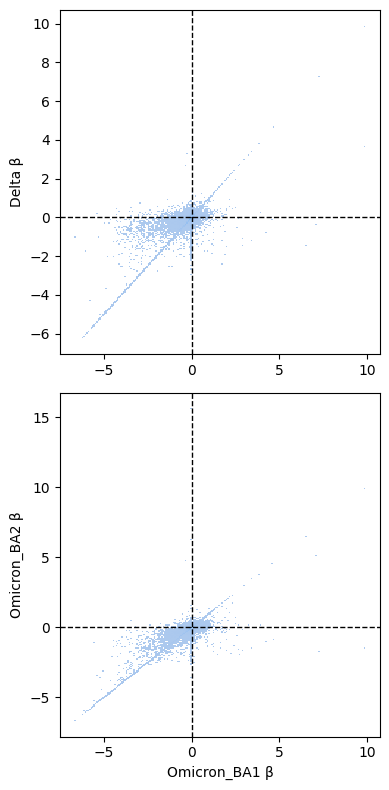

In [34]:
plt.figure(figsize=(4, 8))

plt.subplot(211)
ax = sns.histplot(x=model.φ["Omicron_BA1"].β, y=model.φ["Delta"].β)
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.ylabel("Delta β")

plt.subplot(212, sharex=ax)
sns.histplot(x=model.φ["Omicron_BA1"].β, y=model.φ["Omicron_BA2"].β)
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.xlabel("Omicron_BA1 β")
plt.ylabel("Omicron_BA2 β")

plt.tight_layout()
plt.show()

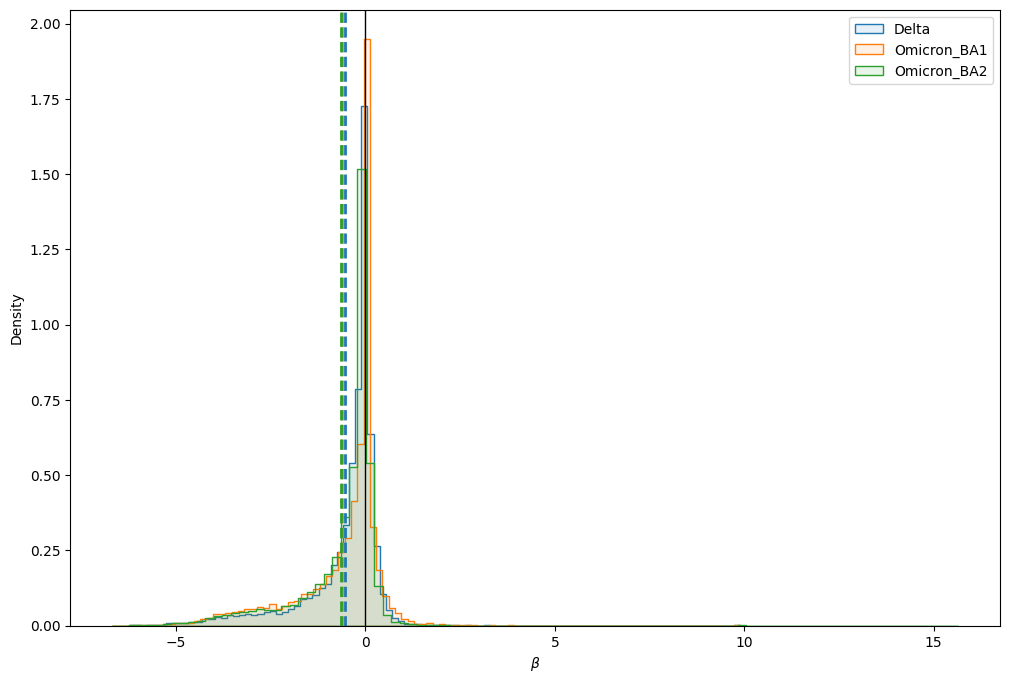

In [35]:
plt.figure(figsize=(12, 8))
for i, d in enumerate(model.φ):
    sns.histplot(x=model.φ[d].β, label=d, bins=100, color=f"C{i}", element="step", fill=True, alpha=0.1, stat="density")
    plt.axvline(model.φ[d].β.mean(), color=f"C{i}", lw=2, linestyle="--")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()